In [54]:
base_path='/kaggle/input/in-breast/INbreast'
train_path='/kaggle/input/in-breast/INbreast/train'
val_path='/kaggle/input/in-breast/INbreast/val'
test_path='/kaggle/input/in-breast/INbreast/test'

# import needed libraries 

In [12]:
from keras.layers import Input, Flatten
from skimage.io import imshow,imread
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers.experimental import AdamW
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory


In [13]:
batch_size = 32
target_size=(224, 224)
class_mode='categorical'

# image data generator 

In [14]:
def generate_dataset(path):
    print("\nTotal for trainning : ", end=" ")
    ds = image_dataset_from_directory(path + '/train',
                                      image_size=target_size,
                                          batch_size=batch_size)
    class_names = ds.class_names
    print(class_names)
    num_classes=len(ds.class_names) 


    image_data_generator = ImageDataGenerator(rescale = 1./255,
                                      fill_mode = 'nearest',
                                      samplewise_std_normalization=True,
                                      samplewise_center=True,
                                      horizontal_flip=True,
                                      vertical_flip=True,
                                      )
    test_image_data_generator = ImageDataGenerator(rescale = 1./255)

    print("\nFor Training : ", end=" ")
    train_generator = image_data_generator.flow_from_directory(train_path,
                                                      target_size=target_size,
                                                      batch_size=batch_size,
                                                      class_mode='categorical',
                                                      interpolation="nearest",
                                                      color_mode='rgb')


    print("\nFor Val : ", end=" ")
    validation_generator = image_data_generator.flow_from_directory(val_path,
                                                           target_size=target_size,
                                                           batch_size=batch_size,
                                                           class_mode='categorical',
                                                           shuffle = False,
                                                           interpolation="nearest",
                                                           color_mode='rgb')
    print("\nFor Test : ", end=" ")
    test_generator = test_image_data_generator.flow_from_directory(test_path,
                                                           target_size=target_size,
                                                           batch_size=batch_size,
                                                           class_mode='categorical',
                                                           shuffle=False,
                                                           interpolation="nearest",
                                                           color_mode='rgb')
    plt.figure(figsize=(30, 30))
    for images, labels in ds.take(1):
        for i in range(num_classes):
            ax = plt.subplot(9, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]]) 
            plt.axis("off")

    return train_generator,validation_generator,test_generator,train_generator.image_shape,class_names,num_classes

# VGG16 Model

In [15]:
def initiate_model_VGG16(no_of_classes, image_size,fine_tune=0,dropout=0.0):
    vgg=VGG16(include_top=False,
        weights='imagenet',
        input_shape=image_size,
        classes=no_of_classes
    )

    if fine_tune > 0:
        for layer in vgg.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in vgg.layers:
            layer.trainable = False  

    top_model = Flatten(name="flatten")(vgg.output)
    top_model = Dense(4096, activation='relu')(top_model)
    top_model = Dense(4096, activation='relu')(top_model)
    if dropout > 0 :
        top_model = Dropout(dropout)(top_model)
        output_layer  = Dense(no_of_classes, activation='softmax')(top_model)

    model = Model(inputs=vgg.input, outputs= output_layer,name="VGG16")
    return model

In [16]:
#Applying Bilateral filter
import cv2 #image processing
import os

def bilateral_filter(image, d, sigma_color, sigma_space): #sigma_color (Controls color similarity)
                                                          #sigma_space(controls spatial proximity)

    filtered_image = cv2.bilateralFilter(image, d, sigma_color, sigma_space)
    return filtered_image

def process_images_in_folder(folder_path, output_folder, d, sigma_color, sigma_space):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for filename in os.listdir(folder_path): #It iterates over the images in the specified folder
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(folder_path, filename) #Constructs the full path to the current image file by joining the folder_path
            original_image = cv2.imread(image_path)

            filtered_image = bilateral_filter(original_image, d, sigma_color, sigma_space)

            output_path = os.path.join(output_folder, filename)
            cv2.imwrite(output_path, filtered_image)

diameter = 15
sigma_color = 75
sigma_space = 75


input_folder = '/kaggle/input/in-breast/INbreast/test/Benign Masses'  # Replace with the path to your input folder
output_folder = '/kaggle/working/filteredoutput'

process_images_in_folder(input_folder, output_folder, diameter, sigma_color, sigma_space)

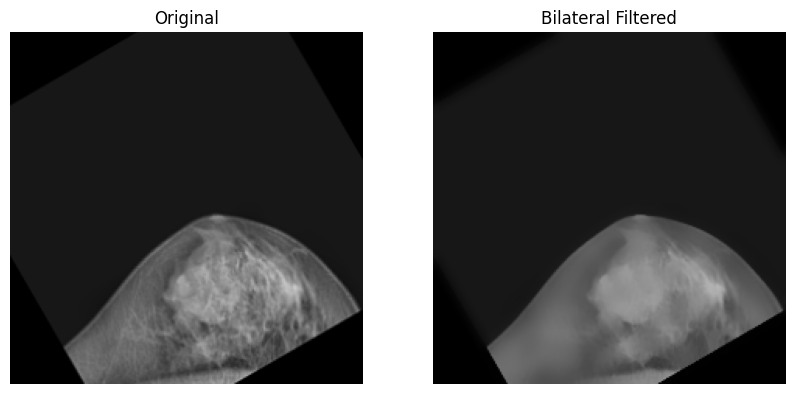

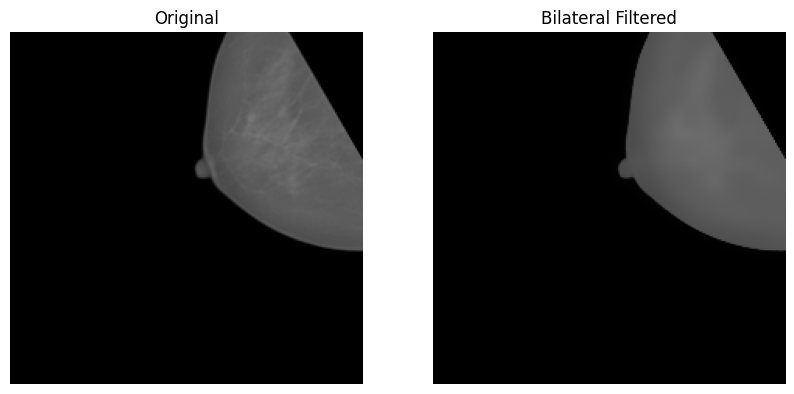

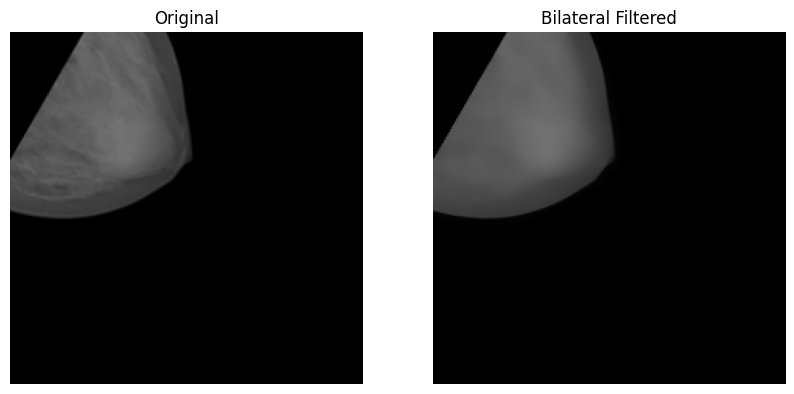

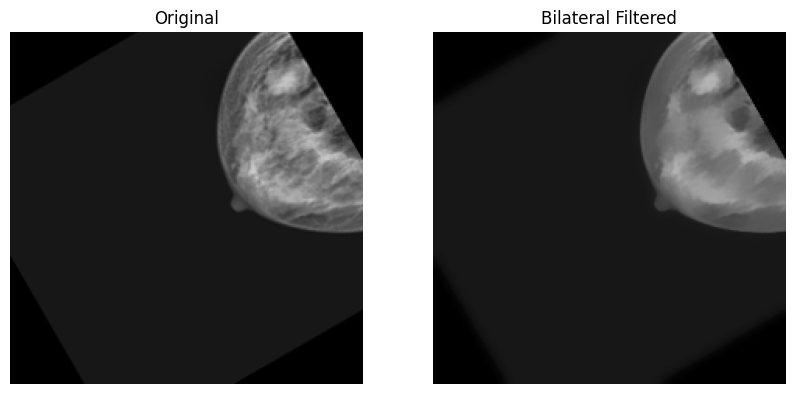

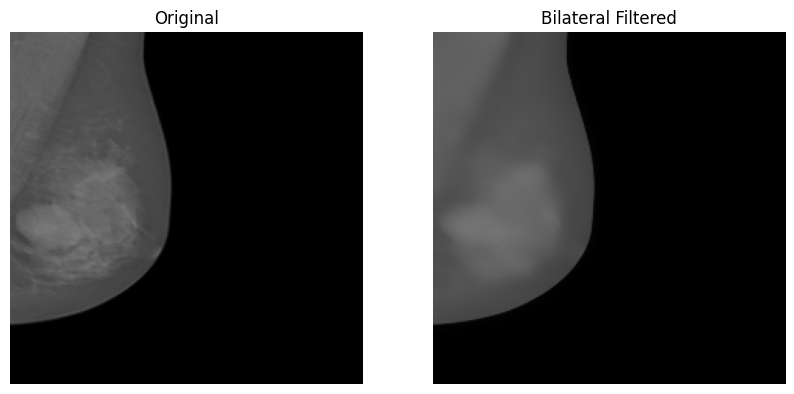

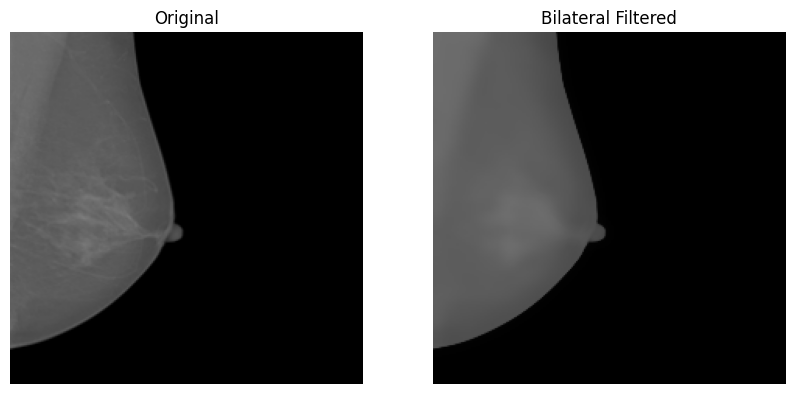

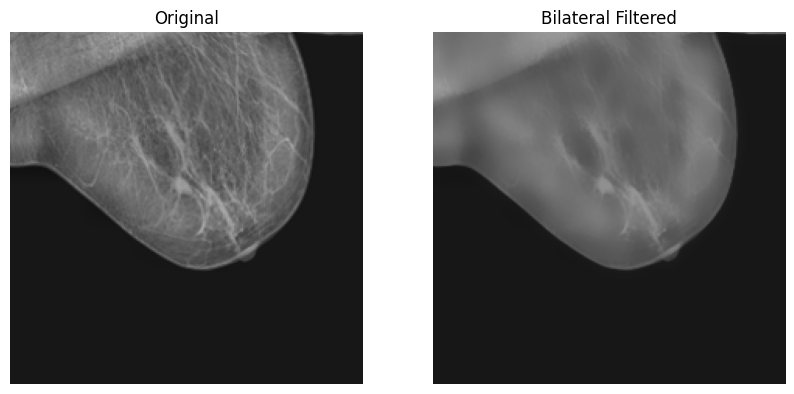

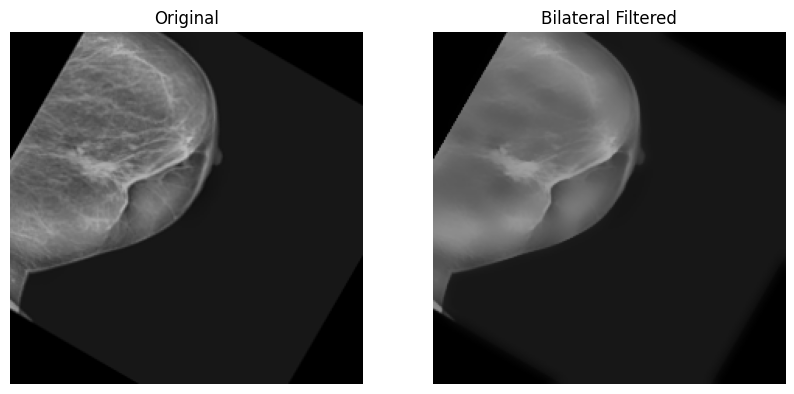

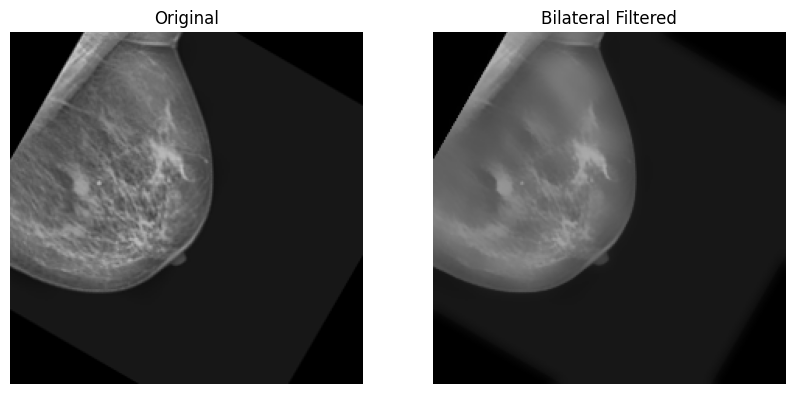

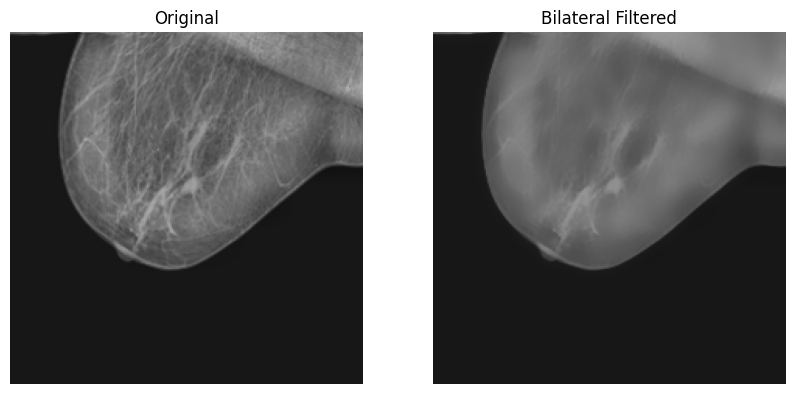

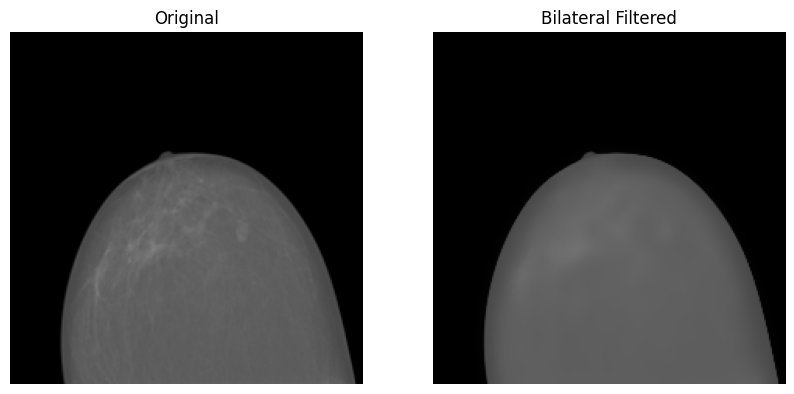

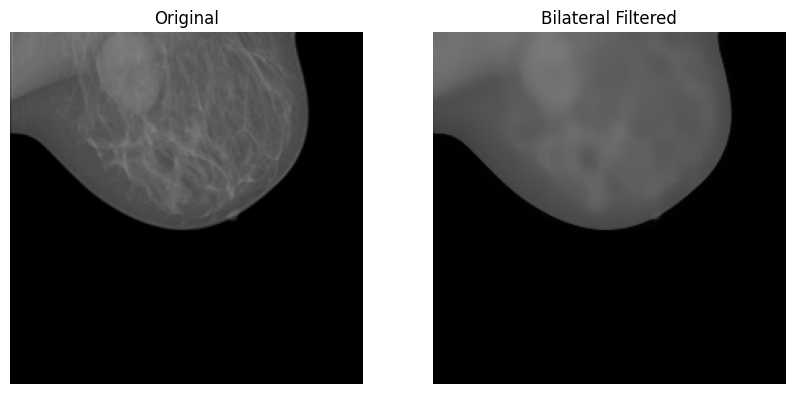

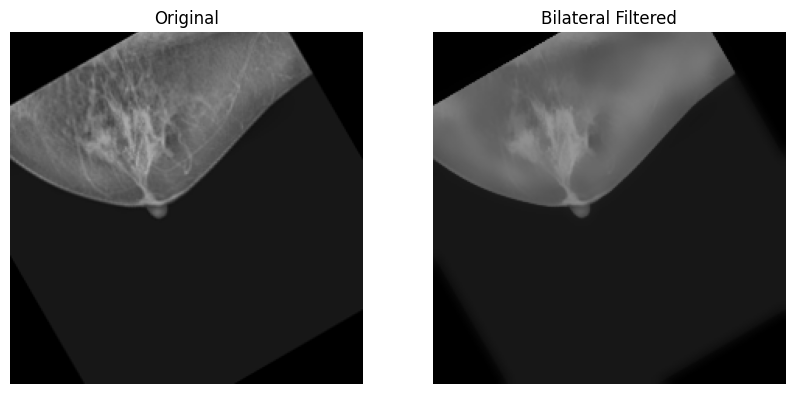

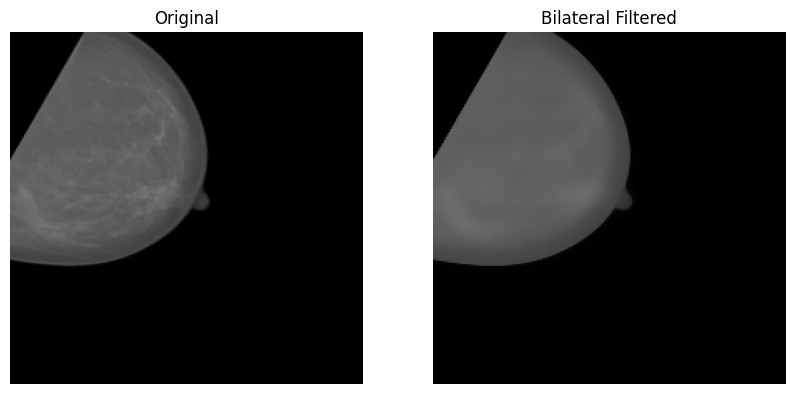

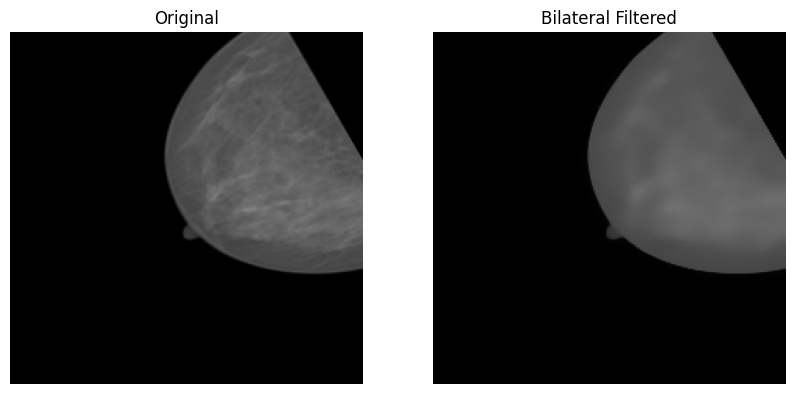

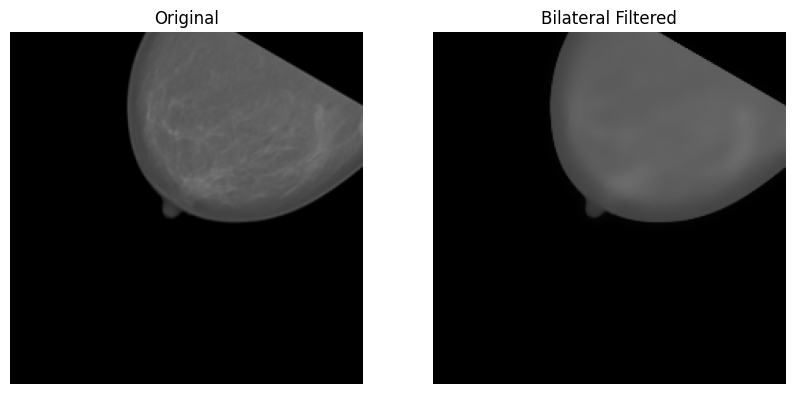

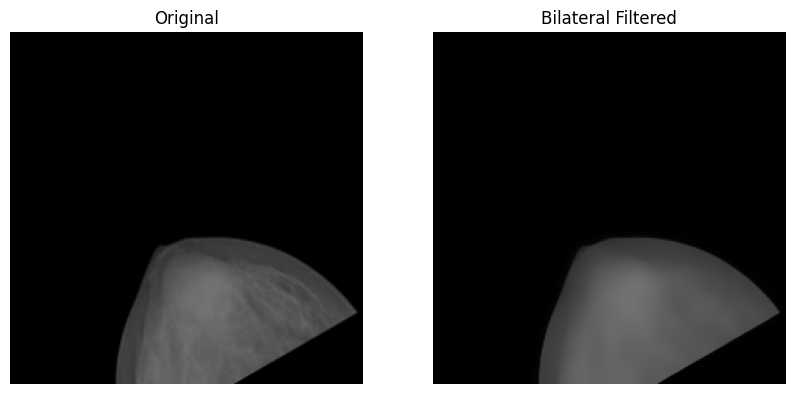

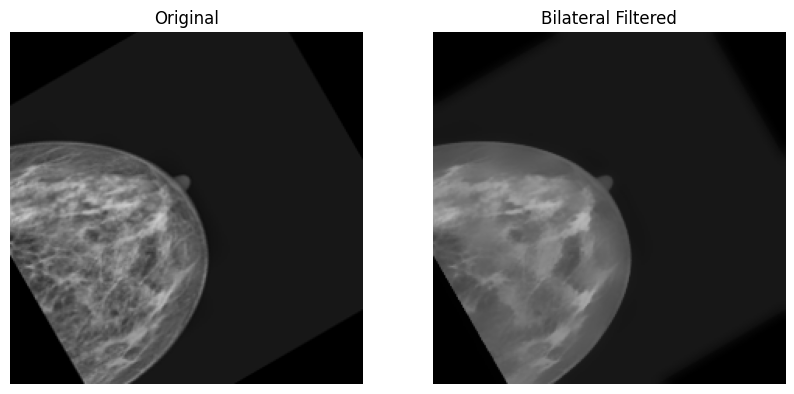

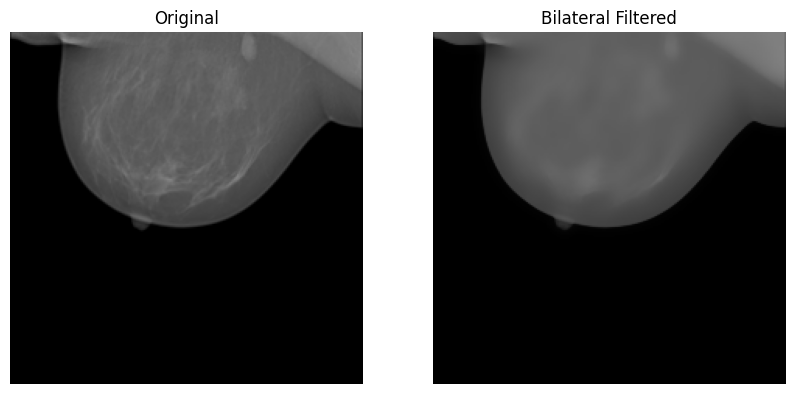

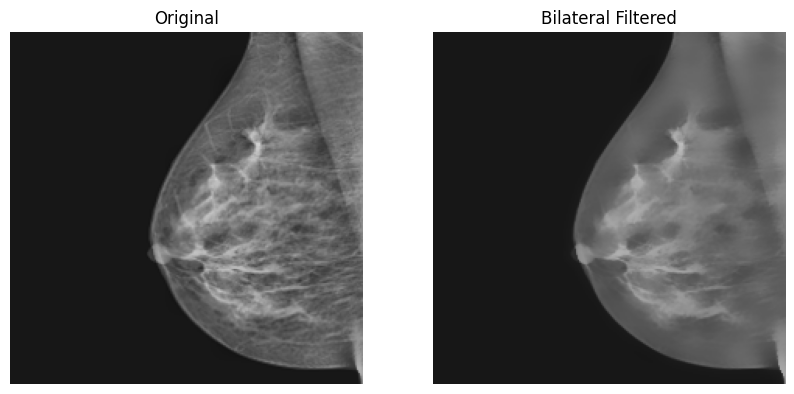

In [55]:
import os
import cv2
import matplotlib.pyplot as plt

def bilateral_filter(image, d, sigma_color, sigma_space):
    filtered_image = cv2.bilateralFilter(image, d, sigma_color, sigma_space)
    return filtered_image

def display_images(original_image, filtered_image, title_original="Original Image", title_filtered="Filtered Image"):
    plt.figure(figsize=(10, 5))

    # Display original image
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    plt.title(title_original)
    plt.axis('off')

    # Display filtered image
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(filtered_image, cv2.COLOR_BGR2RGB))
    plt.title(title_filtered)
    plt.axis('off')
    plt.show()

def process_and_display_images(input_folder, d, sigma_color, sigma_space, max_images=20):
    image_counter = 0
    for filename in os.listdir(input_folder):
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(input_folder, filename)
            original_image = cv2.imread(image_path)

            # Apply bilateral filter
            filtered_image = bilateral_filter(original_image, d, sigma_color, sigma_space)

            # Display original and filtered images
            display_images(original_image, filtered_image, title_original="Original", title_filtered="Bilateral Filtered")
            image_counter += 1

            if image_counter >= max_images:
                break

# Example usage
diameter = 15
sigma_color = 75
sigma_space = 75

input_folder = '/kaggle/input/in-breast/INbreast/test/Benign Masses'
process_and_display_images(input_folder, diameter, sigma_color, sigma_space)


In [18]:
#ROI images extraction
import cv2
import os

def bilateral_filter(image, d, sigma_color, sigma_space):
    filtered_image = cv2.bilateralFilter(image, d, sigma_color, sigma_space)
    return filtered_image

def extract_roi(image):
    # Convert the image to grayscale for contour detection
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply binary thresholding (you may need to adjust the threshold value)
    _, thresh = cv2.threshold(gray, 120, 255, cv2.THRESH_BINARY)

    # Find contours in the thresholded image
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  # A loop iterates through each contour found in the image.

    # Extract ROIs based on the contours
    rois = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        roi = image[y:y+h, x:x+w]
        rois.append(roi)

    return rois

def process_images_in_folder(folder_path, output_folder, d, sigma_color, sigma_space):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for filename in os.listdir(folder_path): #it iterates over the images in the specified folder
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(folder_path, filename) ##Constructs the full path to the current image file by joining the folder_path
            original_image = cv2.imread(image_path)

            filtered_image = bilateral_filter(original_image, d, sigma_color, sigma_space)

            # Extract ROIs from the filtered image
            rois = extract_roi(filtered_image)

            # Save each ROI as a separate image
            for i, roi in enumerate(rois):
                roi_filename = f"{filename.split('.')[0]}_roi_{i+1}.png"
                output_path = os.path.join(output_folder, roi_filename)
                cv2.imwrite(output_path, roi)

diameter = 10
sigma_color = 75
sigma_space = 75

input_folders = '/kaggle/working/filteredoutput'
output_folders = '/kaggle/working/roi'
process_images_in_folder(input_folders, output_folders, diameter, sigma_color, sigma_space)

## Model Summary

In [19]:
def modelSummary(model):
    model.summary()

## Model compile and set check point and callbacks

In [20]:
def initiateParams_modelComplie(model, learning_rate):
    optimizer=AdamW(learning_rate=learning_rate)

    model.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics = [tf.keras.metrics.Recall()]
                )
    rlr = ReduceLROnPlateau(monitor='val_loss',
                               factor=0.5,
                               patience=4,
                               verbose=1,
                               mode='auto',
                               min_lr=1e-5,
                               min_delta=0.001)

    checkpoint = ModelCheckpoint('VGG16.h5',
                               verbose=1,
                               save_best_only=True)

    return model,rlr, checkpoint

## model fit

In [21]:
def modelFit(model, rlr, checkpoint, epochs=15, batchSize = 32):

    model_fit = model.fit(
      train_ds,
      validation_data=val_ds,
      epochs=epochs,
      batch_size=batchSize,
      callbacks=[rlr, checkpoint]
    )

    return model_fit


Total for trainning :  Found 7632 files belonging to 2 classes.
['Benign Masses', 'Malignant Masses']

For Training :  Found 7632 images belonging to 2 classes.

For Val :  Found 7427 images belonging to 2 classes.

For Test :  Found 7427 images belonging to 2 classes.


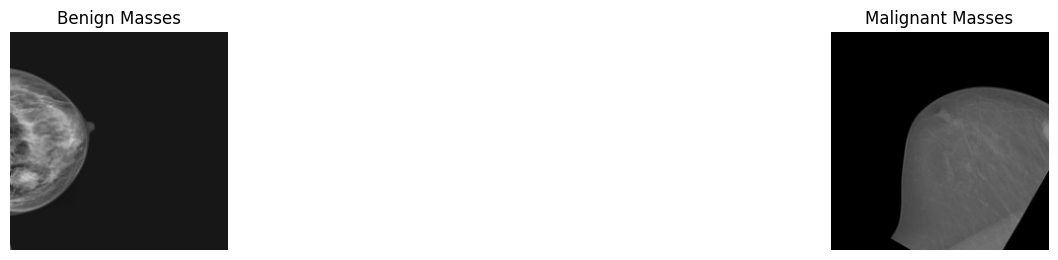

In [57]:
train_ds,val_ds,test_ds,image_batch,class_names,num_classes=generate_dataset(base_path)

## Model Evaluation

In [23]:
def evalModel(model,dataset=test_ds):
    evl = model.evaluate(dataset)
    acc = evl[1]*100
    msg=f'recall on the Test Set = {acc:5.2f} %'
    print(msg)
    return acc


## function to save model

In [24]:
def saveModel(model):
    model.save("/kaggle/working/VGG16.h5")
    print("Model Saved!")

## visualize model preformance

In [25]:
def plotOutput(hist_vgg,str=''):
    acc_vgg = hist_vgg.history['recall'+str]
    val_acc_vgg = hist_vgg.history['val_recall'+str]

    loss_vgg = hist_vgg.history['loss']
    val_loss_vgg =hist_vgg.history['val_loss']

    plt.figure(figsize=(12, 12))
    plt.subplot(3, 2, 1)
    plt.plot(acc_vgg, label='Training recall')
    plt.plot(val_acc_vgg, label='Validation recall')
    plt.legend(loc='lower right')
    plt.xlabel('Epochs')
    plt.ylabel('recall')
    
    
    
    
    plt.title('Training and Validation recall ')
    
    plt.subplot(3, 2, 2)
    plt.plot( loss_vgg, label='Training Loss')
    plt.plot( val_loss_vgg, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.xlabel('Epochs')
    plt.ylabel('loss')
    plt.title('Training and Validation Loss')
    
    plt.show()
    plt.savefig('_graph.png')

## confusion matrix

In [26]:
def plot_confusion_matrix(model,classes,dataset=test_ds):

    y_true = dataset.classes
    y_pred = model.predict(dataset)
    y_pred = np.argmax(y_pred, axis=1)
    conf_mat = confusion_matrix(y_true, y_pred)
    accuracy = np.trace(conf_mat) / float(np.sum(conf_mat))
    misclass = 1 - accuracy
    ConfusionMatrixDisplay(confusion_matrix=conf_mat).plot()
    

## Breast Cancer

# USING DROPOUT AND FINE TUNING 


## VGG16 model

In [27]:
model=initiate_model_VGG16(num_classes,
                                 image_batch,fine_tune=2,dropout=0.2)


58889256/58889256 [==============================] - 0s 0us/step


*Model* summary

In [28]:
modelSummary(model)

Model: "VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

initiate parameters

In [29]:
model_vgg, rlr, checkpoint=initiateParams_modelComplie(model=model,
                                                       learning_rate=0.001)

## Fit the Model

In [30]:
model_fit = modelFit(model_vgg,
                    rlr,
                  checkpoint,
                   epochs=15,
                   batchSize = 32)

Epoch 1/15
219/219 [==============================] - ETA: 0s - loss: 0.5046 - recall: 0.9689
Epoch 1: val_loss improved from inf to 0.04182, saving model to VGG16.h5
219/219 [==============================] - 173s 742ms/step - loss: 0.5046 - recall: 0.9689 - val_loss: 0.0418 - val_recall: 0.9913 - lr: 0.0010
Epoch 2/15
219/219 [==============================] - ETA: 0s - loss: 0.0496 - recall: 0.9879
Epoch 2: val_loss improved from 0.04182 to 0.02530, saving model to VGG16.h5
219/219 [==============================] - 80s 366ms/step - loss: 0.0496 - recall: 0.9879 - val_loss: 0.0253 - val_recall: 0.9940 - lr: 0.0010
Epoch 3/15
219/219 [==============================] - ETA: 0s - loss: 0.0417 - recall: 0.9903
Epoch 3: val_loss did not improve from 0.02530
219/219 [==============================] - 74s 339ms/step - loss: 0.0417 - recall: 0.9903 - val_loss: 0.0344 - val_recall: 0.9927 - lr: 0.0010
Epoch 4/15
219/219 [==============================] - ETA: 0s - loss: 0.0327 - recall: 0.99

## Save Model

In [31]:
saveModel(model_vgg)

Model Saved!


# Model evaluation

In [32]:
accuracy=evalModel(model_vgg)

47/47 [==============================] - 26s 560ms/step - loss: 0.1345 - recall: 0.9700
recall on the Test Set = 97.00 %


## Model preformance

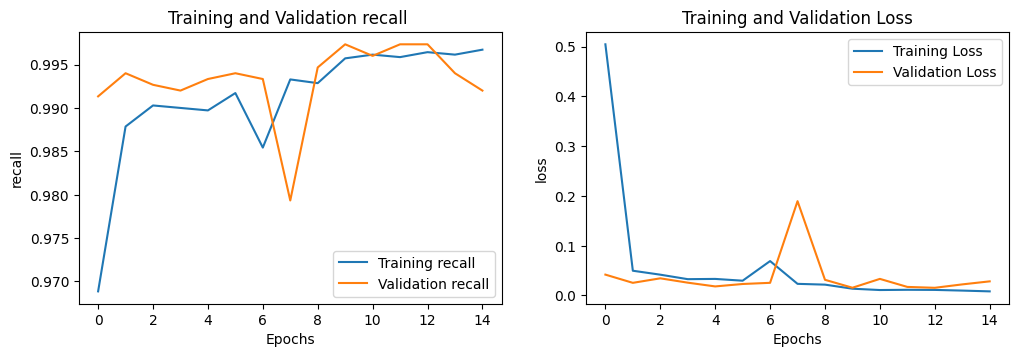

<Figure size 640x480 with 0 Axes>

In [33]:
plotOutput(hist_vgg=model_fit,str='')

## Confusion Matrix

47/47 [==============================] - 11s 227ms/step


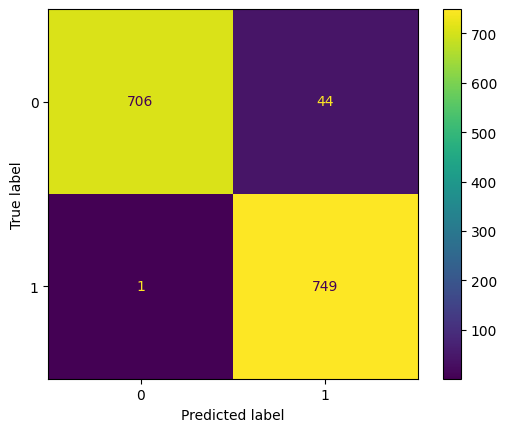

In [34]:
plot_confusion_matrix(model_vgg, classes=class_names)

In [35]:
import os

def generate_class_names(dataset_path):
    class_names = sorted(os.listdir(dataset_path))
    return class_names

# Replace 'path_to_your_dataset' with the actual path to your dataset
dataset_path = '/kaggle/input/breast-cancer/Breast Cancer/train'
class_names = generate_class_names(dataset_path)

print("Class Names:", class_names)


Class Names: ['breast_benign', 'breast_malignant']


In [36]:
!python --version

Python 3.10.10


In [37]:
import keras
import tensorflow as tf
import skimage
from tensorflow.keras import __version__ as keras_version
from tensorflow import __version__ as tf_version
from skimage import __version__ as skimage_version

print("Keras version:", keras_version)
print("TensorFlow version:", tf_version)
print("Scikit-image version:", skimage_version)


Keras version: 2.11.0
TensorFlow version: 2.11.0
Scikit-image version: 0.20.0


In [38]:
from sklearn.metrics import classification_report

# Generate predictions for the test dataset
y_pred = model_vgg.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

# Get true labels from the test dataset
y_true = test_ds.classes

# Generate classification report
report = classification_report(y_true, y_pred, target_names=class_names)

# Print the classification report
print(report)


47/47 [==============================] - 11s 229ms/step
                  precision    recall  f1-score   support

   breast_benign       1.00      0.94      0.97       750
breast_malignant       0.94      1.00      0.97       750

        accuracy                           0.97      1500
       macro avg       0.97      0.97      0.97      1500
    weighted avg       0.97      0.97      0.97      1500



**RESNET50 MODEL**

In [39]:
from tensorflow.keras.applications import ResNet50

# Function to initiate ResNet50 model
def initiate_model_ResNet50(no_of_classes, image_size, fine_tune=0, dropout=0.0):
    resnet = ResNet50(include_top=False,
                      weights='imagenet',
                      input_shape=image_size,
                      classes=no_of_classes
                      )

    if fine_tune > 0:
        for layer in resnet.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in resnet.layers:
            layer.trainable = False  

    top_model = Flatten(name="flatten")(resnet.output)
    top_model = Dense(4096, activation='relu')(top_model)
    top_model = Dense(4096, activation='relu')(top_model)
    if dropout > 0 :
        top_model = Dropout(dropout)(top_model)
    output_layer  = Dense(no_of_classes, activation='softmax')(top_model)
    model = Model(inputs=resnet.input, outputs=output_layer, name="ResNet50")
    return model


In [40]:
# Initialize ResNet50 model
model_resnet = initiate_model_ResNet50(num_classes, image_batch, fine_tune=2, dropout=0.2)


94765736/94765736 [==============================] - 0s 0us/step


In [41]:
# Display model summary
modelSummary(model_resnet)


Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [42]:
# Compile model
model_resnet, rlr, checkpoint = initiateParams_modelComplie(model=model_resnet, learning_rate=0.001)


In [43]:
# Fit model
model_fit = modelFit(model_resnet, rlr, checkpoint, epochs=15, batchSize=32)

Epoch 1/15
219/219 [==============================] - ETA: 0s - loss: 4.2258 - recall_1: 0.8180
Epoch 1: val_loss improved from inf to 0.33326, saving model to VGG16.h5
219/219 [==============================] - 114s 502ms/step - loss: 4.2258 - recall_1: 0.8180 - val_loss: 0.3333 - val_recall_1: 0.8793 - lr: 0.0010
Epoch 2/15
219/219 [==============================] - ETA: 0s - loss: 0.2764 - recall_1: 0.8929
Epoch 2: val_loss did not improve from 0.33326
219/219 [==============================] - 74s 337ms/step - loss: 0.2764 - recall_1: 0.8929 - val_loss: 0.3484 - val_recall_1: 0.8727 - lr: 0.0010
Epoch 3/15
219/219 [==============================] - ETA: 0s - loss: 0.2161 - recall_1: 0.9197
Epoch 3: val_loss improved from 0.33326 to 0.24504, saving model to VGG16.h5
219/219 [==============================] - 99s 454ms/step - loss: 0.2161 - recall_1: 0.9197 - val_loss: 0.2450 - val_recall_1: 0.9153 - lr: 0.0010
Epoch 4/15
219/219 [==============================] - ETA: 0s - loss: 0.1

In [44]:
# Save model
saveModel(model_resnet)


Model Saved!


In [45]:
# Evaluate model
accuracy = evalModel(model_resnet)


47/47 [==============================] - 12s 256ms/step - loss: 1.6123 - recall_1: 0.5213
recall on the Test Set = 52.13 %


47/47 [==============================] - 12s 234ms/step


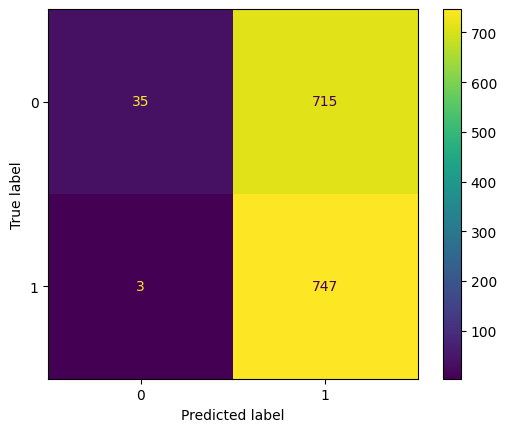

In [51]:
# Plot confusion matrix
plot_confusion_matrix(model_resnet, classes=class_names)

In [52]:
from sklearn.metrics import classification_report

# Generate predictions for the test dataset
y_pred = model_resnet.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

# Get true labels from the test dataset
y_true = test_ds.classes

# Generate classification report
report = classification_report(y_true, y_pred, target_names=class_names)

# Print the classification report
print(report)


47/47 [==============================] - 11s 237ms/step
                  precision    recall  f1-score   support

   breast_benign       0.92      0.05      0.09       750
breast_malignant       0.51      1.00      0.68       750

        accuracy                           0.52      1500
       macro avg       0.72      0.52      0.38      1500
    weighted avg       0.72      0.52      0.38      1500

